In [1]:
import cv2
import imghdr
import os
import tensorflow as tf

In [2]:
data_dir = 'data'

In [3]:
image_exts = ['jpeg', 'jpg', 'bpm', 'png']

In [ ]:
os.listdir(os.path.join(data_dir, 'interior'))

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('not img')
                os.remove(image_path)
        except Exception as e:
            print(f'error {e}')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import os
os.listdir()
!mkdir ./data
!mkdir ./data/external
!mkdir ./data/interior

!ls ./data
# os.getcwd()
# os.chdir('/home/ec2-user/SageMaker/InteriorExterior/')
!rmdir './data/.ipynb_checkpoints'

### next


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data')

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

In [ ]:
batch[1]

In [8]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Class 0: ext
Class 1 : int

## Data preprocessing

In [9]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
data.as_numpy_iterator().next()[0].max()

1.0

split train/test

In [11]:
str(len(data)) + ' batches'

'156 batches'

In [12]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1) + 1
test_size = int(len(data)*.1) + 1

In [13]:
(train_size,
val_size,
test_size)

(124, 16, 16)

In [70]:
train = data.take(train_size) 
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

#### Train

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [148]:
model = Sequential()

In [149]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3), data_format='channels_last'))
model.add(MaxPooling2D(data_format='channels_last'))

model.add(Conv2D(32, (3,3), 1, activation='relu', data_format='channels_last'))
model.add(MaxPooling2D( data_format='channels_last'))

model.add(Conv2D(16, (3,3), 1, activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(data_format='channels_last'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [150]:
model.compile('adam', loss=tf.losses.binary_crossentropy, metrics=['accuracy'])

In [151]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

In [152]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [172]:
new_hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback], initial_epoch=3)

Epoch 4/5
399/399 [==============================] - 1036s 3s/step - loss: 0.0168 - accuracy: 0.9951 - val_loss: 0.0344 - val_accuracy: 0.9919
Epoch 5/5
399/399 [==============================] - 1394s 3s/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.0402 - val_accuracy: 0.9875


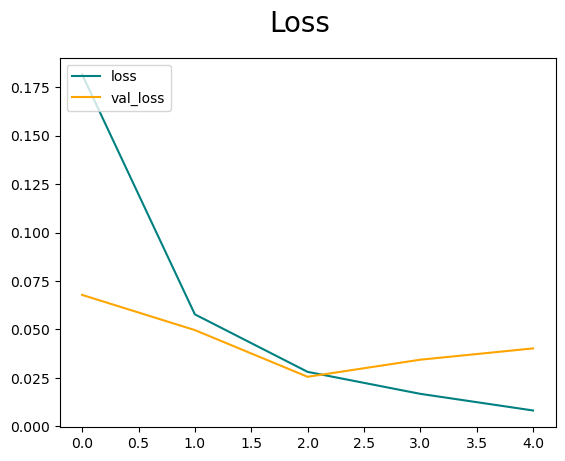

In [175]:
fig = plt.figure()
plt.plot(hist.history['loss']+new_hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss']+new_hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

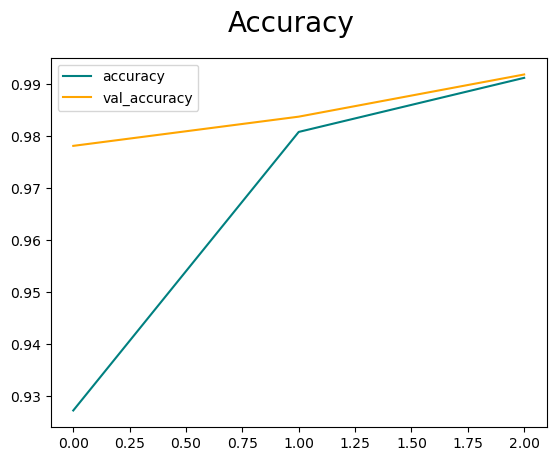

In [155]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## performance

In [71]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [72]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [74]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = new_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 243ms/step


In [200]:
yhat

array([[0.00340549]], dtype=float32)

In [75]:
print(f'Precission: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

Precission: 1.0, Recall: 0.9966124892234802, Accuracy: 0.9966487884521484


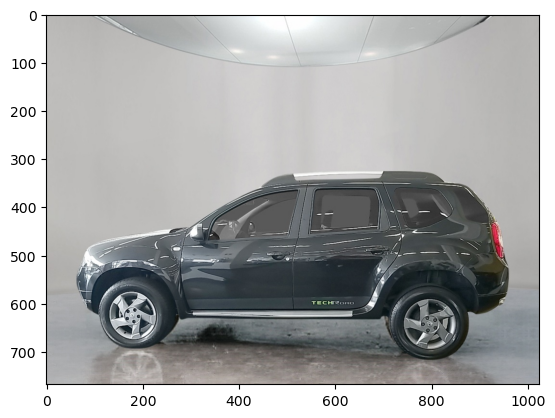

In [17]:
img=cv2.imread('data/external/42.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

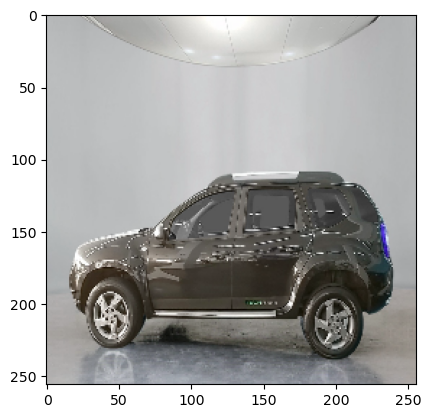

In [18]:
resize = tf.image.resize(img, (256,256))
# plt.imshow(cv2.cvtColor(resize.numpy().astype(int), cv2.COLOR_BGR2RGB))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [19]:
np.expand_dims(resize, 0)

array([[[[184. , 186. , 187. ],
         [183. , 185. , 186. ],
         [184. , 186. , 187. ],
         ...,
         [179. , 181. , 182. ],
         [179. , 181. , 182. ],
         [177. , 179. , 180. ]],

        [[184. , 186. , 187. ],
         [184. , 186. , 187. ],
         [183. , 185. , 186. ],
         ...,
         [179. , 181. , 182. ],
         [179. , 181. , 182. ],
         [179. , 181. , 182. ]],

        [[184. , 186. , 187. ],
         [184. , 186. , 187. ],
         [183. , 185. , 186. ],
         ...,
         [178.5, 180.5, 181.5],
         [179. , 181. , 182. ],
         [179. , 181. , 182. ]],

        ...,

        [[176.5, 176.5, 176.5],
         [179. , 179. , 179. ],
         [177. , 177. , 177. ],
         ...,
         [170. , 163. , 160. ],
         [171. , 164. , 161. ],
         [166. , 161. , 158. ]],

        [[182.5, 182.5, 182.5],
         [182. , 182. , 182. ],
         [181. , 181. , 181. ],
         ...,
         [171.5, 165.5, 160.5],
         [17

In [190]:
# img=cv2.imread('sad_dude.jpg')
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 81ms/step


In [191]:
yhat

array([[0.00340549]], dtype=float32)

In [192]:
if yhat < 0.5:
    print('Exterior')
else:
    print('Interior')

Exterior


## Save Model

In [3]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
import numpy as np

In [15]:
# model.save(os.path.join('models', 'interan_ext_1.h5'))

In [16]:
new_model = load_model(os.path.join('models', 'interan_ext_1.h5'))

2023-04-03 18:39:55.353483: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [198]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 251ms/step


array([[0.00340549]], dtype=float32)

### Fine Tune ImageNet

In [263]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        print(image_path)
        print(os.path.join(image_class, image))

data/external/9417.jpg
external/9417.jpg
data/external/12595.jpg
external/12595.jpg
data/external/8247.jpg
external/8247.jpg
data/external/14495.jpg
external/14495.jpg
data/external/2321.jpg
external/2321.jpg
data/external/8246.jpg
external/8246.jpg
data/external/12968.jpg
external/12968.jpg
data/external/7407.jpg
external/7407.jpg
data/external/6616.jpg
external/6616.jpg
data/external/12911.jpg
external/12911.jpg
data/external/7871.jpg
external/7871.jpg
data/external/2298.jpg
external/2298.jpg
data/external/16412.jpg
external/16412.jpg
data/external/16663.jpg
external/16663.jpg
data/external/10705.jpg
external/10705.jpg
data/external/17036.jpg
external/17036.jpg
data/external/14931.jpg
external/14931.jpg
data/external/13599.jpg
external/13599.jpg
data/external/4092.jpg
external/4092.jpg
data/external/10159.jpg
external/10159.jpg
data/external/17124.jpg
external/17124.jpg
data/external/887.jpg
external/887.jpg
data/external/10093.jpg
external/10093.jpg
data/external/9016.jpg
external/9

## Train using AWS Sagemaker

In [265]:
import boto3

s3 = boto3.client('s3')

bucket_name = 'data-cars'
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        if image_class == 'interior':
            image_path = os.path.join(data_dir, image_class, image)


            s3_key = f'training/input/train/{os.path.join(image_class, image)}'
            try:
                s3.upload_file(image_path, bucket_name, s3_key)
            except Exception as e:
                print(e)


[Errno 21] Is a directory: 'data/interior/.ipynb_checkpoints'


In [ ]:
import sagemaker
from sagemaker.tensorflow import TensorFlow
import boto3
from sagemaker import get_execution_role

# Get the execution role
role = get_execution_role()
# Set up the SageMaker session and role
sagemaker_session = sagemaker.Session()


# Define the S3 bucket and prefix for input and output data
bucket = 'data-cars
'
input_prefix = 'training/input'
output_prefix = 'output'

# Define the path to your training script
source_dir = '/home/ec2-user/SageMaker/InteriorExterior'
entry_point = 'train.py'

# Define the hyperparameters for the training job
hyperparameters = {'epochs': 10, 'batch-size': 32}

# Define the training instance type and count
instance_type = 'ml.p2.xlarge'
instance_count = 1

# Define the estimator
estimator = TensorFlow(entry_point=entry_point,
                       source_dir=source_dir,
                       role=role,
                       framework_version='2.11',
                       py_version='py39',
                       instance_count=instance_count,
                       instance_type=instance_type,
                       hyperparameters=hyperparameters,
                       output_path=f's3://{bucket}/{output_prefix}',
                       code_location=f's3://{bucket}/{input_prefix}',
                       metric_definitions=[
       {'Name': 'train:error', 'Regex': 'Train_error=(.*?);'},
       {'Name': 'validation:error', 'Regex': 'Valid_error=(.*?);'}
    ])

# Start the training job
estimator.fit(inputs={'train': f's3://{bucket}/{input_prefix}/train'},
              job_name='my-training-job5')


get_models

In [7]:
import boto3

s3 = boto3.client('s3')


obj  = s3.get_object(Bucket='data-cars', Key='output/my-training-job4/output/model.tar.gz')

In [43]:
import boto3

s3 = boto3.client('s3')
bucket_name = 'data-cars'
key = 'output/my-training-job4/output/model.tar.gz'
local_file_path = 'model.tar.gz'

response = s3.get_object(Bucket=bucket_name, Key=key)
body = response['Body'].read()

# Save the contents to a local file
with open(local_file_path, 'wb') as f:
    f.write(body)

print(f"The file has been downloaded to {local_file_path}")


The file has been downloaded to model.tar.gz


In [45]:
!tar -xzf model.tar.gz
!rm model.tar.gz